In [ ]:
#!/bin/python3
import csv, random, argparse
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from gensim.models import KeyedVectors
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import string
import re

#NonComplasory Module
# import matplotlib.pyplot as plt
# import seaborn as sns
import time
sns.set()

class news_HAN_dataset(Dataset):
    def __init__(self,path,num_sntnc,num_word,embad_model,embedlen,train_data=True):
        self.data_frame=pd.read_csv(path,'data/news-train.csv')
        self.model=embad_model
        self.sen_per_review=num_sntnc
        self.word_per_sen=num_word
        self.embedlen=embedlen
        self.train_data=train_data
        remove_char='"#$%&\'()*+-/:;<=>@[\\]^_`{|}~'
        self.table = str.maketrans('', '',remove_char)
#         if 'zz' in self.word_count:
#             self.word_count['zz']+=len(self)*self.h-self.total_word
#         else:
#             self.word_count['zz']=len(self)*self.h-self.total_word
#         self.total_word=len(self)*self.h
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        return {'review':self.data_dict[idx]['review'],'rating':self.data_dict[idx]['rating']}
    
    def init_vocab(self):
        self.vocab,self.not_invocab,self.word_count,self.total_word = self.get_vacabulary()
    
    def init_vocab_with_dataset(self,data_set):
        self.vocab,self.not_invocab,self.word_count,self.total_word = \
        data_set.vocab,data_set.not_invocab,data_set.word_count,data_set.total_word
    
    def init_data_dict(self):
        self.data_dict=self.build_data_dict_fixed_dim()
        
    def init_data_dict_with_dataset(self,data_set):
        self.data_dict=data_set.data_dict
    
    def init_vocab_embed(self):
        self.vocabmat=torch.rand(self.embedlen,len(self.vocab)+1)
        self.indtoword={}
        self.wordtoind={}
        for i,w in enumerate(self.vocab):
            self.indtoword[i]=w
            self.wordtoind[w]=i
            #             self.vocabmat[:,i]=torch.tensor(self.model[w]/np.linalg.norm(self.model[w]),device=device)
        self.indtoword[len(self.vocab)]='PADD_NULL'
        self.wordtoind['PADD_NULL']=int(len(self.vocab))
        self.vocabmat[:,len(self.vocab)]=torch.tensor(self.model['za']*0)   
        
    def init_vocab_embed_with_dataset(self,data_set):
        self.vocabmat=data_set.vocabmat
        self.indtoword=data_set.indtoword
        self.wordtoind=data_set.wordtoind
        
    def init_vocab_parameter(self):#order of initializasation matters here
        self.init_vocab()
        self.init_vocab_embed()
        self.init_data_dict()
        
    def init_vocab_parameter_with_dataset(self,data_set):
        self.init_vocab_with_dataset(data_set)
        self.init_vocab_embed_with_dataset(data_set)
        self.init_data_dict_with_dataset(data_set)
        
    def get_vacabulary(self):
        vocab=set()
        not_invocab=set()
        vocab.add('za')
        word_count={}
        word_count['za']=0
        total_word=0
        for i in range(len(self)):
            pp1=json.loads(self.data_frame.loc[i]['description'])
            pp1.append(self.data_frame.loc[i]['title'].split(" "))
            for sen in pp1:
                for w in sen:
                    w1=str.lower(w.translate(self.table))
                    vocab.add(w1)
                    if w1 in word_count:
                        word_count[w1]+=1
                    else:
                        word_count[w1]=1
#                     if w1 in self.model.vocab:
#                         vocab.add(w1)
#                         if w1 in word_count:
#                             word_count[w1]+=1
#                         else:
#                             word_count[w1]=1
#                     else:
#                         not_invocab.add(w1)
#                         word_count['za']+=1
                    total_word+=1
        return vocab,not_invocab,word_count,total_word

#depricated not used by me 
    def build_data_dict(self):
        data_dict={}
        for idx in range(len(self)):
            element={}
            review=[]
            label=0
            pp1=json.loads(self.data_frame.loc[idx]['description'])
            pp1.append(self.data_frame.loc[idx]['title'].split(" "))
            for i,sen in enumerate(pp1):
                temp_l=[]
                for j,w in enumerate(sen):
                    w=w[1:-1]
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.vocab:
                        temp_l.append(self.wordtoind[w1])
                    else:
                        if(w1=="n't"):
                            temp_l.append(self.wordtoind['not'])
                        elif(w1=="'ve"):
                            temp_l.append(self.wordtoind['have'])
                        elif(w1=="'re"):
                            temp_l.append(self.wordtoind['are'])
                        elif(w1=="wo"):
                            temp_l.append(self.wordtoind['will'])
                        else:
                            temp_l.append(self.wordtoind['za'])
                review.append(temp_l)
            element['review']=review
            if(self.train_data):
                label=self.class_dict[self.data_frame.loc[idx]['label']]
                element['rating']=label
                data_dict[idx]=element
        return data_dict
    
    def build_data_dict_fixed_dim(self):
        data_dict={}
        self.class_dict={}
        for i,j in enumerate(self.data_frame.label.unique()):
            self.class_dict[j]=i
        for idx in range(len(self)):
            element={}
            X=torch.zeros(self.sen_per_review,self.word_per_sen,dtype=torch.long) 
            label=0
            pp1=json.loads(self.data_frame.loc[idx]['description'])
            pp1.append(self.data_frame.loc[idx]['title'].split(" "))
            for i,sen in enumerate(pp1):
                if i >=self.sen_per_review:
                    break
                for j,w in enumerate(sen):
                    if j >=self.word_per_sen-1:
                        break
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.vocab:
                        X[i][j]=self.wordtoind[w1]
                    else:
                        if(w1=="n't"):
                            X[i][j]=self.wordtoind['not']
                        elif(w1=="nt"):
                            X[i][j]=self.wordtoind['not']
                        elif(w1=="'ve"):
                            X[i][j]=self.wordtoind['have']
                        elif(w1=="'re"):
                            X[i][j]=self.wordtoind['are']
                        elif(w1=="wo"):
                            X[i][j]=self.wordtoind['will']
                        else:
                            X[i][j]=self.wordtoind['za']
                lj=j
                if(lj<=self.word_per_sen-1):
                    X[i][lj]=self.wordtoind['.']
                    lj+=1
                    while(lj<self.word_per_sen):
                        X[i][lj]=self.wordtoind['PADD_NULL']
                        lj+=1
            li=i
            while(li<self.sen_per_review):
                for j in range(self.word_per_sen):
                    X[li][j]=self.wordtoind['PADD_NULL']
                li+=1
                
            element['review']=X
            if(self.train_data):
                label=self.class_dict[self.data_frame.loc[idx]['label']]
                element['rating']=label
                data_dict[idx]=element
        return data_dict

def data_stats(df):    
    word_len=[]
    sen_count=[]
    word_count=[]
    for i in range(len(df)):
        pp1=json.loads(df.loc[i]['description'])
        sen_count.append(len(pp1))
        for sen in pp1:
            word_count.append(len(sen))
            for k in sen:
                word_len.append(len(k)-2)

    # plt.subplot(211)
#     p_value=90
    percentile=[25,50,75,80,90,95]
    for p_value in percentile:
        plt.title("word_per_sentence plot, total sentence="+str(len(word_count)))
        plt.plot(word_count)
        plt.figtext(.35,.75,str(p_value)+"_percentile ="+str(np.percentile(word_count,p_value)))
        plt.show()
        plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
        # plt.subplot(221)
        plt.plot(sen_count)
        plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
        plt.figtext(.55,.75, str(p_value)+"percentile ="+str(np.percentile(sen_count,p_value)))
        plt.plot(sen_count)
        plt.show()
        
class HAN(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(HAN,self).__init__()
        self.hidden_fsize=hidden_dim
        self.input_fsize=input_dim
        self.w_gru=nn.GRU(self.input_fsize,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.w_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.w_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.s_gru=nn.GRU(self.hidden_fsize*2,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.s_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.s_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.fc=nn.Linear(self.hidden_fsize*2,4)
        self.softmax=nn.Softmax(dim=1)
    def init_wgru(self,gru,seqlen):
        optim.Adam(gru.parameters())
        i=0
        while(True):
            input = torch.zeros(seqlen,1000,gru.input_size,device=device)
            h0 = torch.zeros(2, 1000,gru.hidden_size,device=device)
            output, hn = gru(input, h0)
#             op_zero=torch.zeros(output.shape,device=device)
            loss=torch.sum(torch.abs(output))
            loss.backward()
            optimizer.step()
            if(i%100==0):
                print(loss.item())
            i+=1
            if(loss.item()<0.00001):
                break
    def init_embedding(self,pretrained):
        self.embed=nn.Embedding.from_pretrained(pretrained,freeze='False')
    def forward1(self,XD,S):#X.shape==Batch_size*num_sntnc*num_words
        #iterate over sentences one by one
        for i in range(XD.shape[1]):
            X1=XD[:,i,:]                      #ith sentence
            X=self.embed(X1)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],X.shape[2]).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=(Batch_size*num_sntnc)*num_words*embed_dim
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=(Batch_size*num_sntnc)*num_word*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= (Batch_size*num_sntnc)*num_word
#             w_attention=torch.exp(w_attention)
#             total_attention=(1/torch.sum(w_attention,1))
#             w_attention=w_attention*total_attention.unsqueeze(1).expand_as(w_attention)
            w_attention=F.softmax(w_attention,dim=1)
            sntnci=torch.bmm(w_attention.unsqueeze(1),alpha)
            S[:,i,:]=sntnci.squeeze(1)
#             print('wh',wh.shape)
#             print('alpha',alpha.shape)
#             print('sntnci',sntnci.shape)
#             print('total_attention',total_attention.shape)
#             print('w_attention',w_attention.shape)
#             print('w_atention_sum',torch.sum(w_attention,1))

        S=torch.transpose(S,0,1)
        self.s_gru.flatten_parameters()
        sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
        sh=torch.transpose(sh,0,1)
        salpha=torch.tanh(self.s_fc(sh))
        s_attention=torch.matmul(salpha,self.s_context)
#         s_attention=torch.exp(s_attention)
#         total_sattention=(1/torch.sum(s_attention,1))
#         s_attention=s_attention*total_sattention.unsqueeze(1).expand_as(s_attention)
        s_attention=F.softmax(s_attention,dim=1)
        review=torch.bmm(s_attention.unsqueeze(1),salpha)
        op=self.fc(review.squeeze(1))
#         print('sh',sh.shape)
#         print('salpha',salpha.shape)
#         print('s_attention',s_attention.shape)
#         print('revivew',review.shape)
#         print('op',op.shape)
        return op,w_attention,s_attention

    def forward(self,XD):#X.shape==Batch_size*num_sntnc*num_words
            #iterate over sentences one by one
            X=XD.view(XD.shape[0]*XD.shape[1],XD.shape[2])
            X=self.embed(X)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],self.hidden_fsize).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=Batch_size*num_sntnc*num_words
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=Batch_size*num_sntnc*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= Batch_size*num_sntnc
            w_attention=F.softmax(w_attention,dim=1)
            S=torch.bmm(w_attention.unsqueeze(1),alpha)
            S=S.squeeze(1)
            S=S.view(XD.shape[0],XD.shape[1],S.shape[1])
    #             print('wh',wh.shape)
    #             print('alpha',alpha.shape)
    #             print('sntnci',sntnci.shape)
    #             print('total_attention',total_attention.shape)
    #             print('w_attention',w_attention.shape)
    #             print('w_atention_sum',torch.sum(w_attention,1))

            S=torch.transpose(S,0,1)
            self.s_gru.flatten_parameters()
            sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
            sh=torch.transpose(sh,0,1)
            salpha=torch.tanh(self.s_fc(sh))
            s_attention=torch.matmul(salpha,self.s_context)
            s_attention=F.softmax(s_attention,dim=1)
            review=torch.bmm(s_attention.unsqueeze(1),salpha)
            op=self.fc(review.squeeze(1))
            
    #         print('sh',sh.shape)
    #         print('salpha',salpha.shape)
    #         print('s_attention',s_attention.shape)
    #         print('revivew',review.shape)
    #         print('op',op.shape)
            return op,w_attention,s_attention
    
    
    
if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--train', action='store_true')
#     parser.add_argument('--test', action='store_true')
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("in main")
#     args = parser.parse_args()
    #code
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    filename='glove.6B.50d.txt.word2vec'
    model=KeyedVectors.load_word2vec_format(filename,binary=False)
    
    tau=1
    current=0
    mb_size=500
    total_doc=120000
    channel=1
    loss_ls=[]
    valloss_ls=[]
    train_acc=0
    embedlen=50
    num_sntnc=3
    num_word=40
    start = time.time()
    # news_buffer=news_HAN_dataset('data/news-train.csv',num_sntnc,num_word,model,embedlen)
    # news_buffer.init_vocab_parameter()

    """critical"""
    # Be Remeber to read imdb_buffer newley if make changes in the imdb_HAN_dataset class
    news=torch.load('news_buffer_slen_3_wlen_40_new_preprocessed_without_glov_title_heading_combined')
    print ('It took', time.time()-start)
    
    # torch.save(imdb_buffer,'imdb_buffer_slen_20_wlen_50_new_preprocessed')
    
    # # indb_HAN_dataset Varifier Code
#     news=news_HAN_dataset('data/news-train.csv',num_sntnc,num_word,model,embedlen)
#     news.init_vocab_parameter_with_dataset(news_buffer1)
    # a=imdb[0]['review']
    # for k in a:
    #     for k1 in k:
    #         print(imdb.indtoword[int(k1)])

    indices=list(range(len(news)))
    random.shuffle(indices)
    # train_sampler = SequentialSampler(indices[0:mb_size])
    # val_sampler = SequentialSampler(indices[20000:250000])
    train_sampler = SubsetRandomSampler(indices[0:96000])
    val_sampler = SubsetRandomSampler(indices[96000:120000])
    train_loader=DataLoader(news,batch_size=mb_size,num_workers=16,sampler=train_sampler)
    valid_loader=DataLoader(news,batch_size=mb_size,num_workers=16,sampler=val_sampler)

    han=HAN(news.embedlen,50)
    han.init_embedding(news.vocabmat.t())
    # han.w_gru.load_state_dict(torch.load('w_gru_init_wt'))
    # han.s_gru.load_state_dict(torch.load('s_gru_init_wt'))

    # if torch.cuda.device_count() > 1:
    #     han=nn.DataParallel(han)
    han.to(device=device)

    criterion=nn.CrossEntropyLoss()
    criterion.to(device)
    loss_ls=[]
    optimizer = optim.Adam(han.parameters(),lr=.005)    
    l_r=.005
    print("preprocessing done")
    #     trainer = IMDBClassifier(500,50)
    loss_ls=[280,260,250]
    valloss_ls=[3,2.5,2]

    if True:
        print('Training...')
        itrn=0
        num_itrn=25
        while(itrn<num_itrn):
            train_acc=0
            total_loss=0
            han.train()
            for numbatch,mb in enumerate(train_loader):
    #             print(type(mb))
    #             print(type(mb['review']))
    #             print(mb['review'].shape)
                optimizer.zero_grad()
                X=mb['review'].to(device=device,dtype=torch.long)
                lbl=mb['rating'].to(device=device,dtype=torch.long)
                ylabel,w_a,s_a=han(X)
    #             loss=-torch.mean(lbl*torch.log(.000001+torch.sigmoid(ylabel).reshape(lbl.shape))+(1-lbl)*torch.log(1.000001-torch.sigmoid(ylabel).reshape(lbl.shape)))
                loss=criterion(ylabel,lbl)
                if(torch.isnan(loss).item()):
                    break
                loss.backward()
    #             torch.nn.utils.clip_grad_norm_(han.parameters(),90)
                optimizer.step()
                total_loss=total_loss+loss.item()
                ylabel=F.softmax(ylabel,dim=1).argmax(dim=1)
                temp=torch.sum(ylabel.data.to(torch.long).reshape(lbl.shape)==lbl.data.to(torch.long))
                train_acc+=temp.item()
    #             if(numbatch%10==0):
    #                 print('whh_norm',han.module.w_gru.weight_hh_l0.norm().item())
    #                 print('whh_max',han.module.w_gru.weight_hh_l0.max())
    #                 print('whh_max_grad',han.module.w_gru.weight_hh_l0.grad.max())
    #                 print('batch',numbatch)
    #                 print('batch loss     :-',loss.item())
    #                 print('batch accuracy :-',temp.item()/mb_size)
    #                 print('X.shape',X.shape)
    #             if(han.module.w_gru.weight_hh_l0.grad.max()>100):
    #                 print("gradient expldes batch",numbatch)
    #                 print("itrn",itrn)
    #                 break

            if(torch.isnan(loss).item()):
                    break
            han.eval()
            with torch.no_grad():
                val_acc=0
                val_loss=0
                for (num_val,val_dict) in enumerate(valid_loader):
                    tb=val_dict['review'].to(device,dtype=torch.long) 
                    tlbl=val_dict['rating'].to(device,dtype=torch.long)
                    typred,vwa,vsa=han(tb)
    #                 temp0=-torch.mean(tlbl*torch.log(.000001+torch.sigmoid(typred).reshape(tlbl.shape))+(1-tlbl)*torch.log(1.000001-torch.sigmoid(typred).reshape(tlbl.shape)))
                    temp0=criterion(typred,tlbl)
                    typred=F.softmax(typred,dim=1).argmax(dim=1)
    #                 typred.round_()
                    temp1=torch.sum(typred.data.reshape(tlbl.shape)==tlbl.data)
                    val_acc+=temp1.item()
                    val_loss=temp0.item()
                if(itrn%1==0):
                    print("Training loss      :-",round(total_loss,3))
                    print("Training Accuracy  :-",round(float(train_acc)/96000,3))
                    print("Validation loss    :-",round(val_loss,3))
                    print('Validation Accuracy:-',round(float(val_acc)/24000,3))
    #                 for name, param in han.named_parameters():
    #                     if param.requires_grad:
    #                         print(name,param.grad[0])
    #                         print(name,round(param.data.norm().item(),3))

                if(total_loss > loss_ls[-1] and loss_ls[-1] > loss_ls[-2]):
                    if(l_r >.00001):
                        l_r=l_r/2
                        optimizer = optim.Adam(han.parameters(),lr=l_r)
                        print('lr changed to :-',l_r)
                elif(itrn%10==0 and itrn >10):
                    if(l_r >.00001 and (loss_ls[-10]-total_loss)<1):
                        l_r=l_r/2
                        optimizer = optim.Adam(han.parameters(),lr=l_r)
                        print('lr changed to :-',l_r)
                loss_ls.append(total_loss)
                valloss_ls.append(val_loss)
            itrn+=1
            total_loss=0   
        state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
        torch.save(state,"current_news_han")
    print('Experiment Embeding Trainabale both GRU bais=False 3 setence 40 word')

    if True:
        print('Testing...')
        prediction={}
        for i,j in enumerate(news.data_frame.label.unique()):
            prediction[i]=j

        test_out_file = open('result/news-test-han.csv', 'w')
        test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
        newst= torch.load('news_test_3_40_without_glov_title_heading_combined')
        indices=range(len(newst))
        train_sampler = SequentialSampler(indices)
        train_loader=DataLoader(news,batch_size=1,num_workers=8,sampler=train_sampler)
        df=pd.read_csv('data/news-test.csv')
        test_writer.writerow(['title','description', 'label'])

        trained=torch.load("save_han/han_news_slen_3_wlen_40_new_preprocessed_without_glov_title_heading_combined_89")
        han.load_state_dict(trained['model'])
        optimizer.load_state_dict(trained['optimizer'])

        han.eval()
        count=0
        for (num_batch,mb_dict) in enumerate(train_loader):
                mb=mb_dict['review'].to(device,dtype=torch.long)
                y,twa,tsa=han(mb)
                ypred=F.softmax(y,dim=1).argmax(dim=1)            
    #                 print(int(ypred.item()))
                test_writer.writerow([newst.data_frame.loc[num_batch][0],newst.data_frame.loc[num_batch][1],prediction[int(ypred.item())]])
    #         trainer.predict()
    print("end")

In [1]:
#!/bin/python3
import csv, random, argparse
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from gensim.models import KeyedVectors
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import string
import re
import json

#NonComplasory Module
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

In [2]:
class news_HAN_dataset(Dataset):
    def __init__(self,path,num_sntnc,num_word,embad_model,embedlen,train_data=True):
        self.data_frame=pd.read_csv(path,)
        self.model=embad_model
        self.sen_per_review=num_sntnc
        self.word_per_sen=num_word
        self.embedlen=embedlen
        self.train_data=train_data
        self.class_dict={}
        remove_char='"#$%&\'()*+-/:;<=>@[\\]^_`{|}~'
        self.table = str.maketrans('', '',remove_char)
#         if 'zz' in self.word_count:
#             self.word_count['zz']+=len(self)*self.h-self.total_word
#         else:
#             self.word_count['zz']=len(self)*self.h-self.total_word
#         self.total_word=len(self)*self.h
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        return {'review':self.data_dict[idx]['review'],'rating':self.data_dict[idx]['rating']}
    
    def init_vocab(self):
        self.vocab,self.not_invocab,self.word_count,self.total_word = self.get_vacabulary()
    
    def init_vocab_with_dataset(self,data_set):
        self.vocab,self.not_invocab,self.word_count,self.total_word = \
        data_set.vocab,data_set.not_invocab,data_set.word_count,data_set.total_word
    
    def init_data_dict(self):
        self.data_dict=self.build_data_dict_fixed_dim()
        
    def init_data_dict_with_dataset(self,data_set):
        self.data_dict=data_set.data_dict
    
    def init_vocab_embed(self):
        self.vocabmat=torch.rand(self.embedlen,len(self.vocab)+1)
        self.indtoword={}
        self.wordtoind={}
        for i,w in enumerate(self.vocab):
            self.indtoword[i]=w
            self.wordtoind[w]=i
            #             self.vocabmat[:,i]=torch.tensor(self.model[w]/np.linalg.norm(self.model[w]),device=device)
        self.indtoword[len(self.vocab)]='PADD_NULL'
        self.wordtoind['PADD_NULL']=int(len(self.vocab))
        self.vocabmat[:,len(self.vocab)]=torch.tensor(self.model['za']*0)   
        
    def init_vocab_embed_with_dataset(self,data_set):
        self.vocabmat=data_set.vocabmat
        self.indtoword=data_set.indtoword
        self.wordtoind=data_set.wordtoind
        
    def init_vocab_parameter(self):#order of initializasation matters here
        self.init_vocab()
        self.init_vocab_embed()
        self.init_data_dict()
        
    def init_vocab_parameter_with_dataset(self,data_set):
        self.init_vocab_with_dataset(data_set)
        self.init_vocab_embed_with_dataset(data_set)
        self.init_data_dict_with_dataset(data_set)
        
    def get_vacabulary(self):
        vocab=set()
        not_invocab=set()
        vocab.add('za')
        word_count={}
        word_count['za']=0
        total_word=0
        for i in range(len(self)):
            pp1=json.loads(self.data_frame.loc[i]['description'])
            pp1.append(self.data_frame.loc[i]['title'].split(" "))
            for sen in pp1:
                for w in sen:
                    w1=str.lower(w.translate(self.table))
                    vocab.add(w1)
                    if w1 in word_count:
                        word_count[w1]+=1
                    else:
                        word_count[w1]=1
#                     if w1 in self.model.vocab:
#                         vocab.add(w1)
#                         if w1 in word_count:
#                             word_count[w1]+=1
#                         else:
#                             word_count[w1]=1
#                     else:
#                         not_invocab.add(w1)
#                         word_count['za']+=1
                    total_word+=1
        return vocab,not_invocab,word_count,total_word

#depricated not used by me 
    def build_data_dict(self):
        data_dict={}
        for idx in range(len(self)):
            element={}
            review=[]
            label=0
            pp1=json.loads(self.data_frame.loc[idx]['description'])
            pp1.append(self.data_frame.loc[idx]['title'].split(" "))
            for i,sen in enumerate(pp1):
                temp_l=[]
                for j,w in enumerate(sen):
                    w=w[1:-1]
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.vocab:
                        temp_l.append(self.wordtoind[w1])
                    else:
                        if(w1=="n't"):
                            temp_l.append(self.wordtoind['not'])
                        elif(w1=="'ve"):
                            temp_l.append(self.wordtoind['have'])
                        elif(w1=="'re"):
                            temp_l.append(self.wordtoind['are'])
                        elif(w1=="wo"):
                            temp_l.append(self.wordtoind['will'])
                        else:
                            temp_l.append(self.wordtoind['za'])
                review.append(temp_l)
                
            label=self.class_dict[self.data_frame.loc[idx]['label']]
            element['review']=review
            element['rating']=label
            data_dict[idx]=element
        return data_dict
    
    def build_data_dict_fixed_dim(self):
        data_dict={}
        self.class_dict={}
        for i,j in enumerate(self.data_frame.label.unique()):
            self.class_dict[j]=i
        for idx in range(len(self)):
            element={}
            X=torch.zeros(self.sen_per_review,self.word_per_sen,dtype=torch.long) 
            label=0
            pp1=json.loads(self.data_frame.loc[idx]['description'])
            pp1.append(self.data_frame.loc[idx]['title'].split(" "))
            for i,sen in enumerate(pp1):
                if i >=self.sen_per_review:
                    break
                for j,w in enumerate(sen):
                    if j >=self.word_per_sen-1:
                        break
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.vocab:
                        X[i][j]=self.wordtoind[w1]
                    else:
                        if(w1=="n't"):
                            X[i][j]=self.wordtoind['not']
                        elif(w1=="nt"):
                            X[i][j]=self.wordtoind['not']
                        elif(w1=="'ve"):
                            X[i][j]=self.wordtoind['have']
                        elif(w1=="'re"):
                            X[i][j]=self.wordtoind['are']
                        elif(w1=="wo"):
                            X[i][j]=self.wordtoind['will']
                        else:
                            X[i][j]=self.wordtoind['za']
                lj=j
                if(lj<=self.word_per_sen-1):
                    X[i][lj]=self.wordtoind['.']
                    lj+=1
                    while(lj<self.word_per_sen):
                        X[i][lj]=self.wordtoind['PADD_NULL']
                        lj+=1
            li=i
            while(li<self.sen_per_review):
                for j in range(self.word_per_sen):
                    X[li][j]=self.wordtoind['PADD_NULL']
                li+=1
                
            element['review']=X
            if(self.train_data):
                label=self.class_dict[self.data_frame.loc[idx]['label']]
                element['rating']=label
                data_dict[idx]=element
        return data_dict


In [3]:
def data_stats(df):    
    word_len=[]
    sen_count=[]
    word_count=[]
    for i in range(len(df)):
        pp1=json.loads(df.loc[i]['description'])
        sen_count.append(len(pp1))
        for sen in pp1:
            word_count.append(len(sen))
            for k in sen:
                word_len.append(len(k)-2)

    # plt.subplot(211)
#     p_value=90
    percentile=[25,50,75,80,90,95]
    for p_value in percentile:
        plt.title("word_per_sentence plot, total sentence="+str(len(word_count)))
        plt.plot(word_count)
        plt.figtext(.35,.75,str(p_value)+"_percentile ="+str(np.percentile(word_count,p_value)))
        plt.show()
        plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
        # plt.subplot(221)
        plt.plot(sen_count)
        plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
        plt.figtext(.55,.75, str(p_value)+"percentile ="+str(np.percentile(sen_count,p_value)))
        plt.plot(sen_count)
        plt.show()

In [4]:
class HAN(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(HAN,self).__init__()
        self.hidden_fsize=hidden_dim
        self.input_fsize=input_dim
        self.w_gru=nn.GRU(self.input_fsize,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.w_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.w_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.s_gru=nn.GRU(self.hidden_fsize*2,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.s_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.s_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.fc=nn.Linear(self.hidden_fsize*2,4)
        self.softmax=nn.Softmax(dim=1)
    def init_wgru(self,gru,seqlen):
        optim.Adam(gru.parameters())
        i=0
        while(True):
            input = torch.zeros(seqlen,1000,gru.input_size,device=device)
            h0 = torch.zeros(2, 1000,gru.hidden_size,device=device)
            output, hn = gru(input, h0)
#             op_zero=torch.zeros(output.shape,device=device)
            loss=torch.sum(torch.abs(output))
            loss.backward()
            optimizer.step()
            if(i%100==0):
                print(loss.item())
            i+=1
            if(loss.item()<0.00001):
                break
    def init_embedding(self,pretrained):
        self.embed=nn.Embedding.from_pretrained(pretrained,freeze='False')
    def forward1(self,XD,S):#X.shape==Batch_size*num_sntnc*num_words
        #iterate over sentences one by one
        for i in range(XD.shape[1]):
            X1=XD[:,i,:]                      #ith sentence
            X=self.embed(X1)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],X.shape[2]).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=(Batch_size*num_sntnc)*num_words*embed_dim
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=(Batch_size*num_sntnc)*num_word*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= (Batch_size*num_sntnc)*num_word
#             w_attention=torch.exp(w_attention)
#             total_attention=(1/torch.sum(w_attention,1))
#             w_attention=w_attention*total_attention.unsqueeze(1).expand_as(w_attention)
            w_attention=F.softmax(w_attention,dim=1)
            sntnci=torch.bmm(w_attention.unsqueeze(1),alpha)
            S[:,i,:]=sntnci.squeeze(1)
#             print('wh',wh.shape)
#             print('alpha',alpha.shape)
#             print('sntnci',sntnci.shape)
#             print('total_attention',total_attention.shape)
#             print('w_attention',w_attention.shape)
#             print('w_atention_sum',torch.sum(w_attention,1))

        S=torch.transpose(S,0,1)
        self.s_gru.flatten_parameters()
        sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
        sh=torch.transpose(sh,0,1)
        salpha=torch.tanh(self.s_fc(sh))
        s_attention=torch.matmul(salpha,self.s_context)
#         s_attention=torch.exp(s_attention)
#         total_sattention=(1/torch.sum(s_attention,1))
#         s_attention=s_attention*total_sattention.unsqueeze(1).expand_as(s_attention)
        s_attention=F.softmax(s_attention,dim=1)
        review=torch.bmm(s_attention.unsqueeze(1),salpha)
        op=self.fc(review.squeeze(1))
#         print('sh',sh.shape)
#         print('salpha',salpha.shape)
#         print('s_attention',s_attention.shape)
#         print('revivew',review.shape)
#         print('op',op.shape)
        return op,w_attention,s_attention

    def forward(self,XD):#X.shape==Batch_size*num_sntnc*num_words
            #iterate over sentences one by one
            X=XD.view(XD.shape[0]*XD.shape[1],XD.shape[2])
            X=self.embed(X)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],self.hidden_fsize).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=Batch_size*num_sntnc*num_words
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=Batch_size*num_sntnc*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= Batch_size*num_sntnc
            w_attention=F.softmax(w_attention,dim=1)
            S=torch.bmm(w_attention.unsqueeze(1),alpha)
            S=S.squeeze(1)
            S=S.view(XD.shape[0],XD.shape[1],S.shape[1])
    #             print('wh',wh.shape)
    #             print('alpha',alpha.shape)
    #             print('sntnci',sntnci.shape)
    #             print('total_attention',total_attention.shape)
    #             print('w_attention',w_attention.shape)
    #             print('w_atention_sum',torch.sum(w_attention,1))

            S=torch.transpose(S,0,1)
            self.s_gru.flatten_parameters()
            sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
            sh=torch.transpose(sh,0,1)
            salpha=torch.tanh(self.s_fc(sh))
            s_attention=torch.matmul(salpha,self.s_context)
            s_attention=F.softmax(s_attention,dim=1)
            review=torch.bmm(s_attention.unsqueeze(1),salpha)
            op=self.fc(review.squeeze(1))
            
    #         print('sh',sh.shape)
    #         print('salpha',salpha.shape)
    #         print('s_attention',s_attention.shape)
    #         print('revivew',review.shape)
    #         print('op',op.shape)
            return op,w_attention,s_attention

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filename='glove.6B.50d.txt.word2vec'
model=KeyedVectors.load_word2vec_format(filename,binary=False)

In [6]:
tau=1
current=0
mb_size=500
total_doc=120000
channel=1
loss_ls=[]
valloss_ls=[]
train_acc=0
embedlen=50
num_sntnc=3
num_word=40
start = time.time()
# news_buffer=news_HAN_dataset('data/news-train.csv',num_sntnc,num_word,model,embedlen)
# news_buffer.init_vocab_parameter()

"""critical"""
# Be Remeber to read imdb_buffer newley if make changes in the imdb_HAN_dataset class
news_buffer1=torch.load('news_buffer_slen_3_wlen_40_new_preprocessed_without_glov_title_heading_combined')
print ('It took', time.time()-start)

It took 5.226128339767456


In [7]:
# # indb_HAN_dataset Varifier Code
news=news_HAN_dataset('data/news-train.csv',num_sntnc,num_word,model,embedlen)
news.init_vocab_parameter_with_dataset(news_buffer1)
# a=imdb[0]['review']
# for k in a:
#     for k1 in k:
#         print(imdb.indtoword[int(k1)])

indices=list(range(len(news)))
random.shuffle(indices)
# train_sampler = SequentialSampler(indices[0:mb_size])
# val_sampler = SequentialSampler(indices[20000:250000])
train_sampler = SubsetRandomSampler(indices[0:96000])
val_sampler = SubsetRandomSampler(indices[96000:120000])
train_loader=DataLoader(news,batch_size=mb_size,num_workers=16,sampler=train_sampler)
valid_loader=DataLoader(news,batch_size=mb_size,num_workers=16,sampler=val_sampler)

han=HAN(news.embedlen,50)
han.init_embedding(news.vocabmat.t())
# han.w_gru.load_state_dict(torch.load('w_gru_init_wt'))
# han.s_gru.load_state_dict(torch.load('s_gru_init_wt'))

# if torch.cuda.device_count() > 1:
#     han=nn.DataParallel(han)
han.to(device=device)

criterion=nn.CrossEntropyLoss()
criterion.to(device)
loss_ls=[]

In [9]:
han

HAN(
  (w_gru): GRU(50, 50, bias=False, bidirectional=True)
  (w_fc): Linear(in_features=100, out_features=100, bias=True)
  (s_gru): GRU(100, 50, bias=False, bidirectional=True)
  (s_fc): Linear(in_features=100, out_features=100, bias=True)
  (fc): Linear(in_features=100, out_features=4, bias=True)
  (softmax): Softmax()
  (embed): Embedding(104712, 50)
)

In [8]:
optimizer = optim.Adam(han.parameters(),lr=.005)    

print("preprocessing done")
#     trainer = IMDBClassifier(500,50)

preprocessing done


In [ ]:
data_stats

In [ ]:
# # # # loss_ls=[]
# # # # valloss_ls=[]
# state=torch.load('save_han/han_20_50_train_85')
# han.load_state_dict(state['model'])
# optimizer.load_state_dict(state['optimizer'])

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [25]:
mb['review'].shape
word_attention=w_a.view(500,3,40)

In [26]:
wat_gt_1=(word_attention>.05)

In [27]:
sat_gt_1=(s_a>.08)

In [28]:
sat_gt_1.shape

torch.Size([500, 3])

In [29]:
max_imp_ind=torch.argmax(word_attention,dim=2)

In [30]:
max_sen_ind=torch.argmax(s_a,dim=1)

In [31]:
for i in range(mb['review'].shape[0]):
    for j in range(mb['review'].shape[1]):
        for k in range(mb['review'].shape[2]):
            print('review:',imdb.indtoword[mb['review'][i,j,k].item()])
        for l in range(mb['review'].shape[2]):
            if(wat_gt_1[i,j,l].item()):
                print('most_important_word',imdb.indtoword[mb['review'][i,j,l].item()])
                

NameError: name 'imdb' is not defined

In [32]:
for i in range(0,10):
    print("\033[1;34;40m \n\n\n\n-----------------REVIEW "+str(i)+"------------------")
    for j in range(mb['review'].shape[1]):
        if(sat_gt_1[i,j].item()):
            print("\033[1;33;40m \n\nSEN IMP:-",round(s_a[i,j].item(),3))
            for l in range(mb['review'].shape[2]):
                if(mb['review'][i,j,l].item()!=news.wordtoind['PADD_NULL']):
                    if(wat_gt_1[i,j,l].item()):
                        print("\033[0;31;44m "+str(news.indtoword[mb['review'][i,j,l].item()])+"{ "+str(round(word_attention[i,j,l].item(),3))+" }",end=' ')
                    else:
                        print("\033[0;33;44m",news.indtoword[mb['review'][i,j,l].item()],end=' ')
        else:
            print("\033[1;37;40m \n\nSEN IMP:-",round(s_a[i,j].item(),3))
            for l in range(mb['review'].shape[2]):
                if(mb['review'][i,j,l].item()!=news.wordtoind['PADD_NULL']):
                    if(wat_gt_1[i,j,l].item()):
                        print("\033[1;31;40m "+str(news.indtoword[mb['review'][i,j,l].item()])+"{ "+str(round(word_attention[i,j,l].item(),3))+" }",end=' ')
                    else:
                        print("\033[1;37;40m",news.indtoword[mb['review'][i,j,l].item()],end=' ')

 



-----------------REVIEW 0------------------
 

SEN IMP:- 0.001
 software{ 0.974 }  maker  commerce  one  inc.  ,  seen  as  a  poster  child  for  the  dotcom  bust  ,  is  down  to  its  last      300,000  in  operating  cash  ,  has  laid  off  most  of  its  staff  and  expects  to  file  .  

SEN IMP:- 0.053
 

SEN IMP:- 0.946
 



-----------------REVIEW 1------------------
 

SEN IMP:- 1.0
 space.com{ 0.066 }  { 0.094 }  lives  in  the  eastern  part  of  the  united  states  or  canada  and  gazing  skyward  on  tuesday  evening  may  have  noticed  something  strange  in  their  westnorthwest  sky  .  

SEN IMP:- 0.0
 

SEN IMP:- 0.0
 



-----------------REVIEW 2------------------
 

SEN IMP:- 0.37
 reuters{ 0.995 }    election  day  may  be  in  november  ,  butsome  americans  will  start  casting  ballots  next  week  under  earlyvoting  laws  that  have  reshaped  the  campaign  landscape  andchanged  the  most  fundamental  act  of  democracy  .  

SEN IMP:- 0.016
 


In [ ]:
han.embed(mb['review'][0,0,11].to(device=device))

In [ ]:
imdb.indtoword[mb['review'][0,0,11].item()]

In [ ]:
for i in range(mb['review'].shape[0]):
    for j in range(mb['review'].shape[1]):
        for k in range(mb['review'].shape[2]):
            print(imdb.indtoword[mb['review'][i,j,k].item()])
        print('most_important_word',imdb.indtoword[mb['review'][i,j,max_imp_ind[i,j].item()].item()])

In [ ]:
for name, param in han.named_parameters():
    if param.requires_grad:
        print(name,param.grad)
        print(name,round(param.data.norm().item(),3))

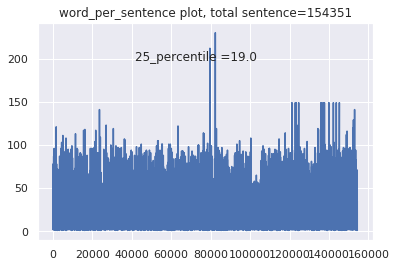

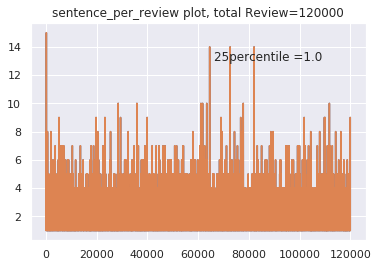

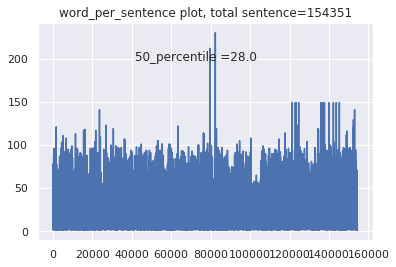

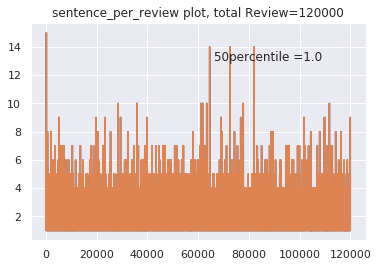

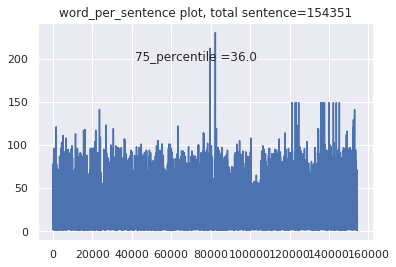

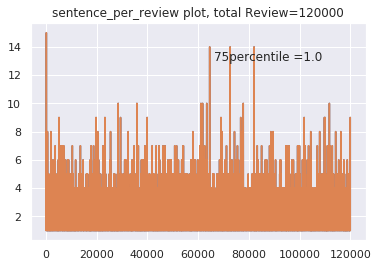

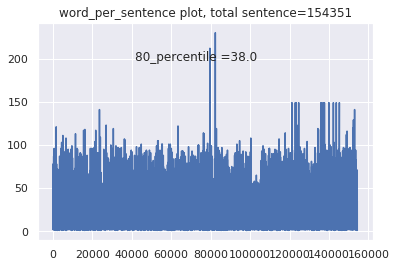

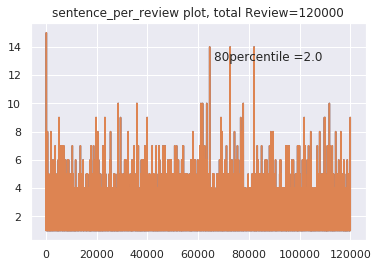

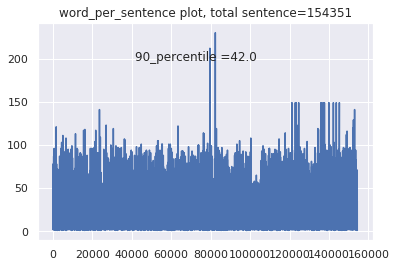

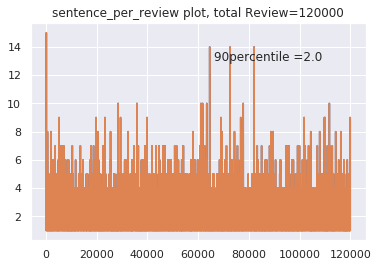

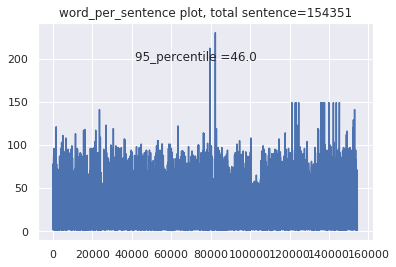

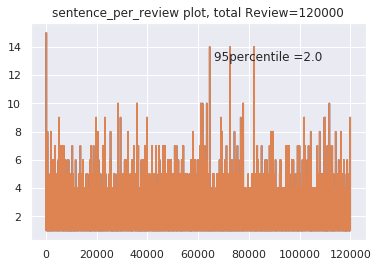

In [22]:
data_stats(news.data_frame)

In [23]:
loss_ls=[280,260,250]
valloss_ls=[3,2.5,2]

if True:
    print('Training...')
    itrn=0
    num_itrn=300
    while(itrn<num_itrn):
        train_acc=0
        total_loss=0
        han.train()
        for numbatch,mb in enumerate(train_loader):
#             print(type(mb))
#             print(type(mb['review']))
#             print(mb['review'].shape)
            optimizer.zero_grad()
            X=mb['review'].to(device=device,dtype=torch.long)
            lbl=mb['rating'].to(device=device,dtype=torch.long)
            ylabel,w_a,s_a=han(X)
#             loss=-torch.mean(lbl*torch.log(.000001+torch.sigmoid(ylabel).reshape(lbl.shape))+(1-lbl)*torch.log(1.000001-torch.sigmoid(ylabel).reshape(lbl.shape)))
            loss=criterion(ylabel,lbl)
            if(torch.isnan(loss).item()):
                break
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(han.parameters(),90)
            optimizer.step()
            total_loss=total_loss+loss.item()
            ylabel=F.softmax(ylabel,dim=1).argmax(dim=1)
            temp=torch.sum(ylabel.data.to(torch.long).reshape(lbl.shape)==lbl.data.to(torch.long))
            train_acc+=temp.item()
#             if(numbatch%10==0):
#                 print('whh_norm',han.module.w_gru.weight_hh_l0.norm().item())
#                 print('whh_max',han.module.w_gru.weight_hh_l0.max())
#                 print('whh_max_grad',han.module.w_gru.weight_hh_l0.grad.max())
#                 print('batch',numbatch)
#                 print('batch loss     :-',loss.item())
#                 print('batch accuracy :-',temp.item()/mb_size)
#                 print('X.shape',X.shape)
#             if(han.module.w_gru.weight_hh_l0.grad.max()>100):
#                 print("gradient expldes batch",numbatch)
#                 print("itrn",itrn)
#                 break

        if(torch.isnan(loss).item()):
                break
        han.eval()
        with torch.no_grad():
            val_acc=0
            val_loss=0
            for (num_val,val_dict) in enumerate(valid_loader):
                tb=val_dict['review'].to(device,dtype=torch.long) 
                tlbl=val_dict['rating'].to(device,dtype=torch.long)
                typred,vwa,vsa=han(tb)
#                 temp0=-torch.mean(tlbl*torch.log(.000001+torch.sigmoid(typred).reshape(tlbl.shape))+(1-tlbl)*torch.log(1.000001-torch.sigmoid(typred).reshape(tlbl.shape)))
                temp0=criterion(typred,tlbl)
                typred=F.softmax(typred,dim=1).argmax(dim=1)
#                 typred.round_()
                temp1=torch.sum(typred.data.reshape(tlbl.shape)==tlbl.data)
                val_acc+=temp1.item()
                val_loss=temp0.item()
            if(itrn%1==0):
                print("Training loss      :-",round(total_loss,3))
                print("Training Accuracy  :-",round(float(train_acc)/96000,3))
                print("Validation loss    :-",round(val_loss,3))
                print('Validation Accuracy:-',round(float(val_acc)/24000,3))
#                 for name, param in han.named_parameters():
#                     if param.requires_grad:
#                         print(name,param.grad[0])
#                         print(name,round(param.data.norm().item(),3))
            
            if(total_loss > loss_ls[-1] and loss_ls[-1] > loss_ls[-2]):
                if(l_r >.00001):
                    l_r=l_r/2
                    optimizer = optim.Adam(han.parameters(),lr=l_r)
                    print('lr changed to :-',l_r)
            elif(itrn%10==0 and itrn >10):
                if(l_r >.00001 and (loss_ls[-10]-total_loss)<1):
                    l_r=l_r/2
                    optimizer = optim.Adam(han.parameters(),lr=l_r)
                    print('lr changed to :-',l_r)
            loss_ls.append(total_loss)
            valloss_ls.append(val_loss)
        if(round(float(train_acc)/96000,3)>0.90):
            state={'model':han.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
            torch.save(state,"save_han/"+"han_train_90_new_preprocessed"+str(itrn))
            break
        itrn+=1
        total_loss=0   
#     state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
#     torch.save(state,"current_imdb")
#Experiment Embeding Trainabale pretarined initialized both GRU bais=False 20 setence 50 word
print('Experiment Embeding Trainabale pretarined initialized both GRU bais=False 2 setence 40 word')

Training...


Process Process-22:
Process Process-24:
Process Process-32:
Process Process-30:
Process Process-26:
Process Process-20:
Process Process-29:
Process Process-17:
Process Process-25:
Process Process-31:
Process Process-21:
Process Process-28:
Process Process-23:
Process Process-18:
Process Process-27:
Process Process-19:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, 

KeyboardInterrupt: 

In [ ]:
news.class

In [ ]:
for i in news.class_dict.keys():
    print(news.class_dict[i])

In [10]:
if True:
    print('Testing...')
    prediction={}
    for i,j in enumerate(news.data_frame.label.unique()):
        prediction[i]=j
    
    test_out_file = open('result/news-test-han.csv', 'w')
    test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
    newst= torch.load('news_test_3_40_without_glov_title_heading_combined')
    indices=range(len(newst))
    train_sampler = SequentialSampler(indices)
    train_loader=DataLoader(news,batch_size=1,num_workers=8,sampler=train_sampler)
    df=pd.read_csv('data/news-test.csv')
    test_writer.writerow(['title','description', 'label'])

    trained=torch.load("save_han/han_news_slen_3_wlen_40_new_preprocessed_without_glov_title_heading_combined_89")
    han.load_state_dict(trained['model'])
    optimizer.load_state_dict(trained['optimizer'])

    han.eval()
    count=0
    for (num_batch,mb_dict) in enumerate(train_loader):
            mb=mb_dict['review'].to(device,dtype=torch.long)
            y,twa,tsa=han(mb)
            ypred=F.softmax(y,dim=1).argmax(dim=1)            
#                 print(int(ypred.item()))
            test_writer.writerow([newst.data_frame.loc[num_batch][0],newst.data_frame.loc[num_batch][1],prediction[int(ypred.item())]])
#         trainer.predict()
print("end")

Testing...
end


In [ ]:
if(round(float(train_acc)/20000,3)>0.85):
    print('yes')

In [ ]:
# print('whh_max_grad',han.module.w_gru.weight_hh_l0.grad.max())

In [ ]:
# han.module.w_gru.weight_hh_l0.grad.max()

In [ ]:
a=torch.Tensor([2])


In [ ]:
imdb.indtoword[1]


In [ ]:
for name, param in han.named_parameters():
    if param.requires_grad:
        print(name,param.grad)
        print(name,round(param.data.norm().item(),3))
        

In [ ]:
plt.plot(range(len(loss_ls)),loss_ls,range(len(valloss_ls)),valloss_ls)

In [ ]:
state={'model':han.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
torch.save(state,"save_han/"+"han_news_slen_3_wlen_40_new_preprocessed_without_glov_title_heading_combined_89")

In [ ]:
assert (typred >= 0. and typred <= 1.).all()

In [ ]:
print("end")